In [12]:
# ============================================================================
# EE200: Signals, Systems and Networks
# Code for Question 2: Frequency De-mixer
# ============================================================================


In [18]:
# ============================================================================
# --- CONFIGURATION AND SETUP ---
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.io import wavfile
import os

# Input file path
AUDIO_PATH = 'song_with_2piccolo.wav'

# Output directory for all generated files
OUTPUT_DIR = 'q2_final_submission_outputs'

# --- Filter Design Parameters for Multiple Bands ---
# Each tuple represents (low_cutoff, high_cutoff, order) for one filter.
FILTER_BANDS = [
    (1000, 2000, 16),  # Filter 1: Main body of piccolo
    (2450, 4150, 16),  # Filter 2: Upper harmonics
    (4300, 5300, 12)   # Filter 3: Highest "air" harmonics
]

# Create the output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"All outputs for Question 2 will be saved in: '{OUTPUT_DIR}/'")


All outputs for Question 2 will be saved in: 'q2_final_submission_outputs/'



PART 1: Analyzing the corrupted audio signal...
Successfully loaded 'song_with_2piccolo.wav' with sampling rate = 48000 Hz.


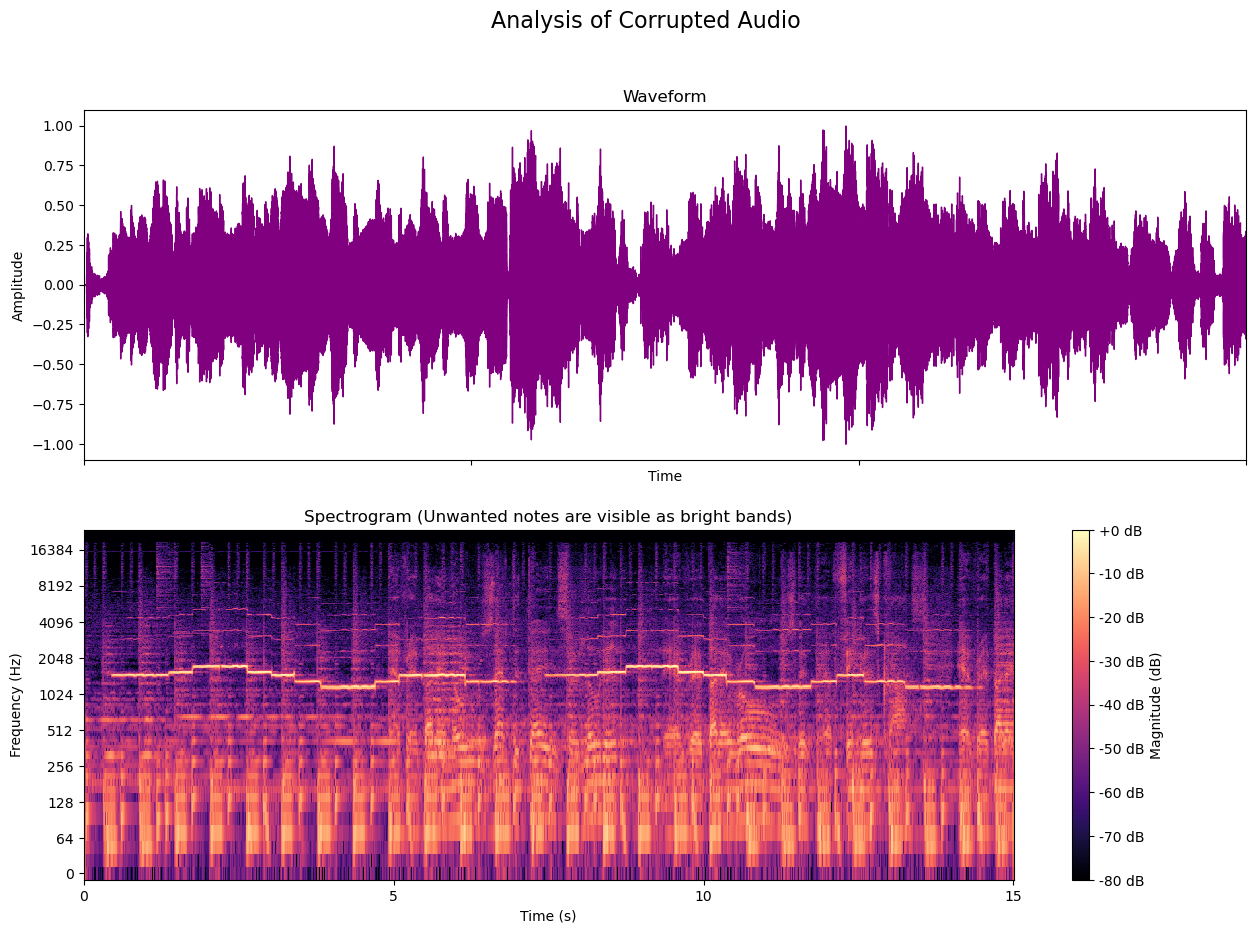

--> Calculating Power Spectral Density to pinpoint problem frequencies...


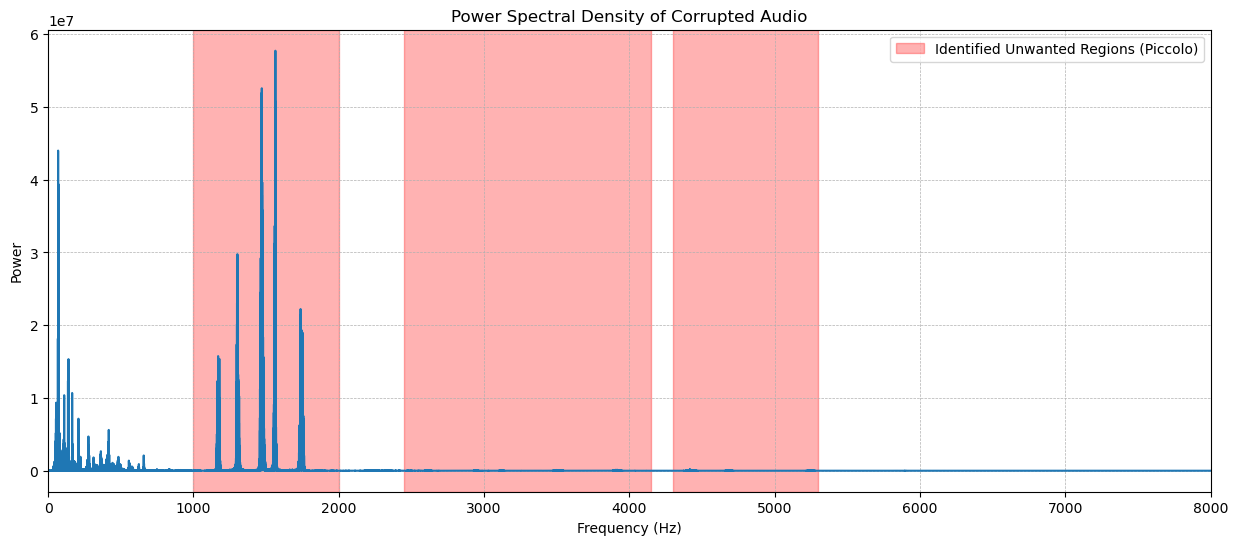

In [19]:
# ============================================================================
# --- PART 1: ANALYSIS OF CORRUPTED AUDIO ---
# ============================================================================

print("\nPART 1: Analyzing the corrupted audio signal...")

try:
    y, sr = librosa.load(AUDIO_PATH, sr=None)
    print(f"Successfully loaded '{AUDIO_PATH}' with sampling rate = {sr} Hz.")
except FileNotFoundError:
    print(f"Error: '{AUDIO_PATH}' not found. Please place it in the correct directory.")
    exit()
except Exception as e:
    print(f"Error loading audio file: {e}")
    exit()

if y.size == 0:
    print("Error: Loaded audio is empty.") 
    exit()

# --- Plot A: Waveform and Spectrogram ---
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig1.suptitle('Analysis of Corrupted Audio', fontsize=16)
librosa.display.waveshow(y, sr=sr, ax=ax1, color='purple')
ax1.set_title('Waveform')
ax1.set_ylabel('Amplitude')

D = librosa.stft(y); S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=ax2)
ax2.set_title('Spectrogram (Unwanted notes are visible as bright bands)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Time (s)')
fig1.colorbar(img, ax=ax2, format='%+2.0f dB', label='Magnitude (dB)')
plt.savefig(os.path.join(OUTPUT_DIR, 'q2_part1a_corrupted_analysis.png'))
plt.show()

# --- Plot B: Power Spectral Density (via FFT) ---
print("--> Calculating Power Spectral Density to pinpoint problem frequencies...")
n_fft = len(y); Y_fft = np.fft.fft(y, n_fft); freq = np.fft.fftfreq(n_fft, d=1/sr)
psd = np.abs(Y_fft)**2
positive_freq_indices = np.where(freq >= 0)
plt.figure(figsize=(15, 6))
plt.plot(freq[positive_freq_indices], psd[positive_freq_indices])
plt.title('Power Spectral Density of Corrupted Audio')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 8000)

# --- Highlight all three regions to filter ---
for i, (low_cut, high_cut, _) in enumerate(FILTER_BANDS):
    label = 'Identified Unwanted Regions (Piccolo)' if i == 0 else ""
    plt.axvspan(low_cut, high_cut, color='red', alpha=0.3, label=label)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, 'q2_part1b_psd_analysis.png'))
plt.show()



PART 2: Designing and analyzing the multi-band-stop filter...
--> Designed 3 separate band-stop filters.


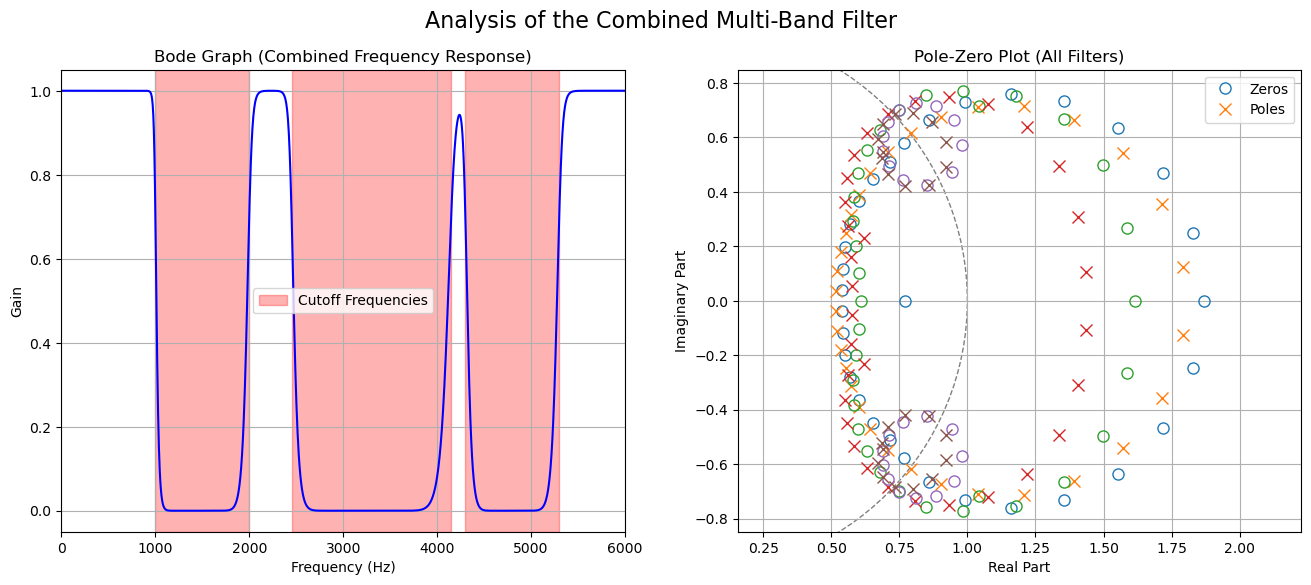

In [20]:
# ============================================================================
# --- PART 2: FILTER DESIGN AND SYSTEM ANALYSIS ---
# ============================================================================

print("\nPART 2: Designing and analyzing the multi-band-stop filter...")

# --- Design multiple filters ---
all_sos_filters = []
all_bode_responses = []
all_pole_zero_data = []
nyquist = 0.5 * sr

for low_cut, high_cut, order in FILTER_BANDS:
    low_norm = low_cut / nyquist
    high_norm = high_cut / nyquist
    # Design filter in stable SOS format for application
    sos = butter(order, [low_norm, high_norm], btype='bandstop', output='sos')
    all_sos_filters.append(sos)
    
    # Get frequency response for combined Bode plot
    w, h = sosfreqz(sos, worN=8000, fs=sr)
    all_bode_responses.append(np.abs(h))
    
    # Get ZPK data for combined Pole-Zero plot
    b, a = butter(order, [low_norm, high_norm], btype='bandstop', output='ba')
    z, p, k = tf2zpk(b, a)
    all_pole_zero_data.append({'z': z, 'p': p})

print(f"--> Designed {len(FILTER_BANDS)} separate band-stop filters.")

# --- Plot C: Bode Graph and Pole-Zero Plot ---
fig2, (ax1_filt, ax2_filt) = plt.subplots(1, 2, figsize=(16, 6))
fig2.suptitle('Analysis of the Combined Multi-Band Filter', fontsize=16)

# Bode Graph (Frequency Response) - shows combined effect
total_response = np.prod(all_bode_responses, axis=0)
ax1_filt.plot(w, total_response, 'b')
ax1_filt.set_title("Bode Graph (Combined Frequency Response)")
ax1_filt.set_xlabel('Frequency (Hz)')
ax1_filt.set_ylabel('Gain')
ax1_filt.grid(True)
ax1_filt.set_xlim(0, 6000) 

# Loop through the filter bands to draw vertical lines for each cutoff
for i, (low_cut, high_cut, _) in enumerate(FILTER_BANDS):
    label = 'Cutoff Frequencies' if i == 0 else ""
    ax1_filt.axvspan(low_cut, high_cut, color='red', alpha=0.3, label=label)
    
ax1_filt.legend()

# Pole-Zero Plot - shows combined poles and zeros
unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
ax2_filt.add_artist(unit_circle)
for i, data in enumerate(all_pole_zero_data):
    label_z = 'Zeros' if i == 0 else ""
    label_p = 'Poles' if i == 0 else ""
    ax2_filt.plot(np.real(data['z']), np.imag(data['z']), 'o', markersize=8, fillstyle='none', label=label_z)
    ax2_filt.plot(np.real(data['p']), np.imag(data['p']), 'x', markersize=8, label=label_p)
ax2_filt.set_title("Pole-Zero Plot (All Filters)")
ax2_filt.set_xlabel("Real Part")
ax2_filt.set_ylabel("Imaginary Part")
ax2_filt.grid(True)
ax2_filt.legend()
ax2_filt.axis('equal')
plt.savefig(os.path.join(OUTPUT_DIR, 'q2_part2_filter_analysis.png'))
plt.show()



PART 3: Applying filter cascade and verifying the result...
--> Applied filter #1...
--> Applied filter #2...
--> Applied filter #3...
--> All filters applied successfully.
--> Restored audio saved to: 'q2_final_submission_outputs\Restored_Audio.wav'


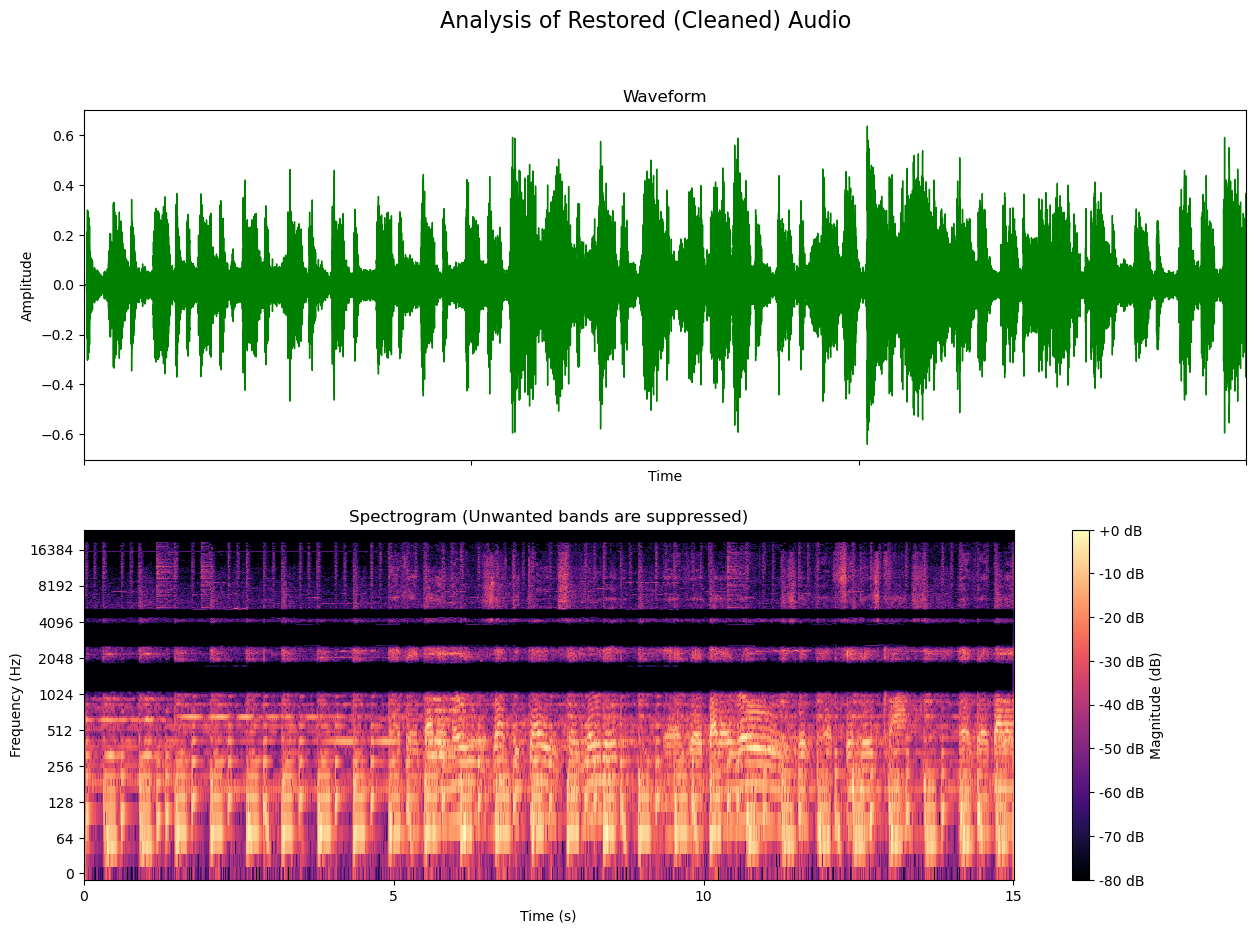

In [21]:
# ============================================================================
# --- PART 3: FILTER APPLICATION AND VERIFICATION ---
# ============================================================================

print("\nPART 3: Applying filter cascade and verifying the result...")

# --- Apply filters sequentially ---
y_filtered = y.copy()
for i, sos in enumerate(all_sos_filters):
    y_filtered = sosfilt(sos, y_filtered)
    print(f"--> Applied filter #{i+1}...")

print("--> All filters applied successfully.")

# --- Export the cleaned audio ---
max_abs = np.max(np.abs(y_filtered))
y_normalized = y_filtered / max_abs if max_abs > 0 else y_filtered
y_int = np.int16(y_normalized * 32767)
restored_audio_path = os.path.join(OUTPUT_DIR, 'Restored_Audio.wav')
wavfile.write(restored_audio_path, sr, y_int)
print(f"--> Restored audio saved to: '{restored_audio_path}'")

# --- Plot D: Analysis of the Restored Audio ---
fig3, (ax1_res, ax2_res) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig3.suptitle('Analysis of Restored (Cleaned) Audio', fontsize=16)
librosa.display.waveshow(y_filtered, sr=sr, ax=ax1_res, color='green')
ax1_res.set_title('Waveform')
ax1_res.set_ylabel('Amplitude')

D_filtered = librosa.stft(y_filtered); S_db_filtered = librosa.amplitude_to_db(np.abs(D_filtered), ref=np.max)
img_res = librosa.display.specshow(S_db_filtered, sr=sr, x_axis='time', y_axis='log', ax=ax2_res)
ax2_res.set_title('Spectrogram (Unwanted bands are suppressed)')
ax2_res.set_ylabel('Frequency (Hz)')
ax2_res.set_xlabel('Time (s)')
fig3.colorbar(img_res, ax=ax2_res, format='%+2.0f dB', label='Magnitude (dB)')
plt.savefig(os.path.join(OUTPUT_DIR, 'q2_part3_restored_analysis.png'))
plt.show()


In [22]:
# ============================================================================
# --- END ---
# ============================================================================
